Modele final: prediction utilisant Designation et Descriptions Camemeber + VIT

In [1]:
import os

import importlib

import RktnChallenge.RktnModel
importlib.reload(RktnChallenge.RktnModel)
from RktnChallenge.RktnModel import ModelTrainer

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam,Adagrad
import numpy as np
import ast

2023-09-29 14:07:13.871451: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-29 14:07:14.480730: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9511] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-09-29 14:07:14.480756: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-09-29 14:07:14.486608: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-29 14:07:14.781792: I tensorflow/core/platform/cpu_feature_guar

In [2]:

# PARAMS  de base
PATH = "images/crop224/"
img_size = 224
depth = 3

from RktnChallenge.RktnModel import ModelTrainer

trainer = ModelTrainer("embeddings_final.csv",PATH)



In [3]:

list_tags = trainer.data.prdtypecode.unique().tolist()
num_categories = len(list_tags)





X_data = trainer.data[["embeddings_desi","embeddings_desc","embedding_vit","designation_length_normalized","description_length_normalized","embeddings_desi_Flaubert"]]

def convert_string_to_nparray(s):    
    # Supprime les caractères non désirés et divise la chaîne en une liste de nombres
    numbers = [float(x) for x in s.replace("[", "").replace("]", "").split()]
    return np.array(numbers)
def translate_string_to_array(s):
    liste_python = ast.literal_eval(s)
    return np.array(liste_python)

X_data.loc[:, 'embeddings_desc'] = X_data['embeddings_desc'].apply(convert_string_to_nparray)
X_data.loc[:, 'embeddings_desi'] = X_data['embeddings_desi'].apply(convert_string_to_nparray)
X_data.loc[:, 'embeddings_desi_Flaubert'] = X_data['embeddings_desi_Flaubert'].apply(convert_string_to_nparray)


X_data.loc[:, 'embedding_vit'] = X_data['embedding_vit'].apply(translate_string_to_array)

y = trainer.encodeLabel("prdtypecode")
label_size = trainer.getLabelSize()


In [4]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size = 0.20, random_state = 42)

X1_train = X_train["embeddings_desi"].values
X1_train = np.stack(X1_train).astype(np.float32)
X2_train = X_train["embeddings_desc"].values
X2_train = np.stack(X2_train).astype(np.float32)
X3_train = X_train["embedding_vit"].values
X3_train = np.stack(X3_train).astype(np.float32)
X4_train = X_train["designation_length_normalized"].values
X5_train = X_train["description_length_normalized"].values
X6_train = X_train["embeddings_desi_Flaubert"].values
X6_train = np.stack(X6_train).astype(np.float32)





X1_test = X_test["embeddings_desi"].values
X1_test = np.stack(X1_test).astype(np.float32)
X2_test = X_test["embeddings_desc"].values
X2_test = np.stack(X2_test).astype(np.float32)
X3_test = X_test["embedding_vit"].values
X3_test = np.stack(X3_test).astype(np.float32)
X4_test = X_test["designation_length_normalized"].values
X5_test = X_test["description_length_normalized"].values
X6_test = X_test["embeddings_desi_Flaubert"].values
X6_test = np.stack(X6_test).astype(np.float32)


#del X_data
del X_test
del X_train

In [5]:
import tensorflow as tf
from tensorflow.keras import backend as K

def f1_weighted(true, pred):  
    # Classes
    classes = K.arange(0, 27) 
    true = K.one_hot(K.cast(true, 'int32'), 27)
    
    # Calcule les TP, FP, FN pour chaque classe
    tp = K.dot(K.transpose(true), K.round(pred))
    fp = K.dot(K.transpose(1-true), K.round(pred))
    fn = K.dot(K.transpose(true), 1-K.round(pred))

    # Calcule le score F1 pour chaque classe
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())
    f1 = 2*p*r / (p+r+K.epsilon())

    # Calculez le score F1 moyen pondéré
    weighted_f1 = K.sum(f1 * K.sum(true, axis=0) / K.sum(true))
    return weighted_f1


In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW,RMSprop
from tensorflow.keras.regularizers import l2

input_1 = Input(shape=(768,), name="input_1")
input_2 = Input(shape=(768,), name="input_2")
input_3 = Input(shape=(768,), name="input_3")
input_4 = Input(shape=(1,), name="input_4")
input_5 = Input(shape=(1,), name="input_5")
input_6 = Input(shape=(768,), name="input_6")


# Concaténer les deux entrées
merged = Concatenate(axis=1)([input_1, input_2,input_3, input_4,input_5,input_6])

x = Dense(1024, activation='relu')(merged)
x = Dropout(0.1)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(256, activation='relu',kernel_regularizer=l2(0.01))(x)
output = Dense(27, activation='softmax')(x)
#optimizer = Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
optimizer = AdamW(weight_decay=1e-5, learning_rate=1e-5, epsilon=1e-08, clipnorm=1.0) 
#optimizer = RMSprop(learning_rate=1e-4)
model = Model(inputs=[input_1, input_2,input_3,input_4,input_5,input_6], outputs=output)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy',f1_weighted])

model.summary()


2023-09-26 20:36:35.627534: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-26 20:36:35.640435: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-26 20:36:35.640647: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                              

2023-09-26 20:36:35.643011: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-26 20:36:35.643491: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-26 20:36:35.643785: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-26 20:36:36.330673: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-26 20:36:36.331015: I external/local_xla/xla

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout,BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW,RMSprop
from tensorflow.keras.regularizers import l2

input_1 = Input(shape=(768,), name="input_1")
input_2 = Input(shape=(768,), name="input_2")
input_3 = Input(shape=(768,), name="input_3")
input_4 = Input(shape=(1,), name="input_4")
input_5 = Input(shape=(1,), name="input_5")
input_6 = Input(shape=(768,), name="input_6")


# Concaténer les deux entrées
merged = Concatenate(axis=1)([input_1, input_2,input_3, input_4,input_5,input_6])

#768
x = Dense(768, activation='relu')(merged)
x = Dropout(0.3)(x)

#512
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
#128
x = Dense(128, activation='relu')(x)

output = Dense(27, activation='softmax')(x)


optimizer = AdamW(weight_decay=1e-5, learning_rate=1e-5, epsilon=1e-08, clipnorm=1.0)

model = Model(inputs=[input_1, input_2,input_3,input_4,input_5,input_6], outputs=output)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy',f1_weighted])

#'sparse_categorical_crossentropy'
model.summary()

2023-09-29 14:10:05.896735: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                              

2023-09-29 14:10:06.211836: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-29 14:10:06.212193: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-29 14:10:06.213829: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-29 14:10:06.214193: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-29 14:10:06.214511: I external/local_xla/xla

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, Lambda,Multiply
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import AdamW

input_1 = Input(shape=(768,), name="input_1")
input_2 = Input(shape=(768,), name="input_2")
input_3 = Input(shape=(768,), name="input_3")


# Le merge des  towers
# Poids pour la moyenne pondérée
w_i1 = tf.Variable(initial_value=tf.ones([768])*0.5, trainable=True, dtype=tf.float32) # initialisé à 0.5, mais entraînable
w_i2 = tf.Variable(initial_value=tf.ones([768])*0.5, trainable=True, dtype=tf.float32) # initialisé à 0.5, mais entraînable

w_i3 = tf.Variable(initial_value=tf.ones([768])*0.5, trainable=True, dtype=tf.float32) # initialisé à 0.5, mais entraînable

w_i4 = tf.Variable(initial_value=tf.zeros([768]), trainable=True, dtype=tf.float32)

# Fusion moyenne pondérée
moyenne = Lambda(lambda features: w_i1 * features[0] + w_i2 * features[1] + w_i3*features[2]+w_i4)([input_1, input_2, input_3])

#produit = Multiply()([input_1, input_2])
#difference = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))([input_1, input_2])


#merged = Concatenate(axis=1)([input_1, input_2])

x = Dense(512, activation='relu')(moyenne)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(27, activation='softmax')(x)

model = Model(inputs=[input_1, input_2, input_3], outputs=output)
optimizer = AdamW(weight_decay=0.01, learning_rate=1e-5, epsilon=1e-08, clipnorm=1.0) 
#optimizer = Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(768,) dtype=float32>
  <tf.Variable 'Variable:0' shape=(768,) dtype=float32>
  <tf.Variable 'Variable:0' shape=(768,) dtype=float32>
  <tf.Variable 'Variable:0' shape=(768,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 lambda (Lambda)             (None, 768)                  0         ['input_1[0][0]',             
                                                                     'input_2[0][0]',       

In [7]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10,)

for h in range(0,2):
    i=0
    for train_index, val_index in kfold.split(np.zeros(len(y_train)), y_train):
        
        X1_train_fold, X1_val_fold = X1_train[train_index], X1_train[val_index]
        X2_train_fold, X2_val_fold = X2_train[train_index], X2_train[val_index]
        X3_train_fold, X3_val_fold = X3_train[train_index], X3_train[val_index]
        X4_train_fold, X4_val_fold = X4_train[train_index], X4_train[val_index]
        X5_train_fold, X5_val_fold = X5_train[train_index], X5_train[val_index]
        X6_train_fold, X6_val_fold = X6_train[train_index], X6_train[val_index]
        
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        if(i==0):
            patience = 4 #6
        else:
            patience = 3 #4
        early_stopper = tf.keras.callbacks.EarlyStopping(
                monitor='val_accuracy', mode='auto', patience=patience, 
                verbose=1, restore_best_weights=True
            ) 
        i+=1
        model.fit([X1_train_fold, X2_train_fold, X3_train_fold, X4_train_fold, X5_train_fold, X6_train_fold], y_train_fold, epochs=30, batch_size=32, validation_data=([X1_val_fold, X2_val_fold,X3_val_fold,X4_val_fold,X5_val_fold,X6_val_fold], y_val_fold),callbacks=[early_stopper])

Epoch 1/30


2023-09-29 14:10:10.778365: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
external_state_policy: POLICY_IGNORE
autotune_options {
}
warm_start: false

2023-09-29 14:10:14.282696: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f462c2c9210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-29 14:10:14.282805: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA TITAN X (Pascal), Compute Capability 6.1
2023-09-29 14:10:14.307339: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-29 14:10:14.635793: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-09-29 14:10:14.714858: I ./tensor

1907/1911 [============================>.] - ETA: 0s - loss: 0.5072 - accuracy: 0.8854 - f1_weighted: 0.8236

2023-09-29 14:10:29.305242: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



1911/1911 [==============================] - 19s 8ms/step - loss: 0.5064 - accuracy: 0.8856 - f1_weighted: 0.8240 - val_loss: 0.1268 - val_accuracy: 0.9635 - val_f1_weighted: 0.9778
Epoch 2/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.1396 - accuracy: 0.9638 - f1_weighted: 0.9756 - val_loss: 0.1122 - val_accuracy: 0.9673 - val_f1_weighted: 0.9813
Epoch 3/30
1911/1911 [==============================] - 14s 7ms/step - loss: 0.1210 - accuracy: 0.9674 - f1_weighted: 0.9787 - val_loss: 0.1029 - val_accuracy: 0.9695 - val_f1_weighted: 0.9829
Epoch 4/30
1911/1911 [==============================] - 14s 7ms/step - loss: 0.1083 - accuracy: 0.9707 - f1_weighted: 0.9812 - val_loss: 0.0951 - val_accuracy: 0.9726 - val_f1_weighted: 0.9839
Epoch 5/30
1911/1911 [==============================] - 14s 7ms/step - loss: 0.1006 - accuracy: 0.9734 - f1_weighted: 0.9830 - val_loss: 0.0951 - val_accuracy: 0.9728 - val_f1_weighted: 0.9842
Epoch 6/30
1911/1911 [========================

2023-09-29 14:15:03.445641: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
external_state_policy: POLICY_IGNORE
autotune_options {
}
warm_start: false



1908/1911 [============================>.] - ETA: 0s - loss: 0.0664 - accuracy: 0.9816 - f1_weighted: 0.9886

2023-09-29 14:15:18.031874: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



1911/1911 [==============================] - 15s 8ms/step - loss: 0.0663 - accuracy: 0.9816 - f1_weighted: 0.9886 - val_loss: 0.0537 - val_accuracy: 0.9854 - val_f1_weighted: 0.9906
Epoch 2/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0648 - accuracy: 0.9824 - f1_weighted: 0.9891 - val_loss: 0.0561 - val_accuracy: 0.9857 - val_f1_weighted: 0.9909
Epoch 3/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0633 - accuracy: 0.9825 - f1_weighted: 0.9892 - val_loss: 0.0560 - val_accuracy: 0.9850 - val_f1_weighted: 0.9906
Epoch 4/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0606 - accuracy: 0.9832 - f1_weighted: 0.9897 - val_loss: 0.0572 - val_accuracy: 0.9850 - val_f1_weighted: 0.9903
Epoch 5/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0610 - accuracy: 0.9831 - f1_weighted: 0.9897 - val_loss: 0.0581 - val_accuracy: 0.9843 - val_f1_weighted: 0.9897
Epoch 5: early stopping
Epoch 1/30
  23/1911 [

2023-09-29 14:16:19.806501: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
external_state_policy: POLICY_IGNORE
autotune_options {
}
warm_start: false



1909/1911 [============================>.] - ETA: 0s - loss: 0.0638 - accuracy: 0.9826 - f1_weighted: 0.9890

2023-09-29 14:16:34.424775: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



1911/1911 [==============================] - 15s 8ms/step - loss: 0.0638 - accuracy: 0.9826 - f1_weighted: 0.9890 - val_loss: 0.0460 - val_accuracy: 0.9882 - val_f1_weighted: 0.9932
Epoch 2/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0621 - accuracy: 0.9824 - f1_weighted: 0.9892 - val_loss: 0.0472 - val_accuracy: 0.9878 - val_f1_weighted: 0.9924
Epoch 3/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0601 - accuracy: 0.9830 - f1_weighted: 0.9895 - val_loss: 0.0487 - val_accuracy: 0.9866 - val_f1_weighted: 0.9927
Epoch 4/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0590 - accuracy: 0.9837 - f1_weighted: 0.9898 - val_loss: 0.0489 - val_accuracy: 0.9872 - val_f1_weighted: 0.9929
Epoch 4: early stopping
Epoch 1/30
  23/1911 [..............................] - ETA: 13s - loss: 0.0440 - accuracy: 0.9864 - f1_weighted: 0.9941

2023-09-29 14:17:21.486824: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
external_state_policy: POLICY_IGNORE
autotune_options {
}
warm_start: false



1906/1911 [============================>.] - ETA: 0s - loss: 0.0627 - accuracy: 0.9824 - f1_weighted: 0.9892

2023-09-29 14:17:35.668458: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



1911/1911 [==============================] - 15s 8ms/step - loss: 0.0629 - accuracy: 0.9824 - f1_weighted: 0.9892 - val_loss: 0.0549 - val_accuracy: 0.9872 - val_f1_weighted: 0.9923
Epoch 2/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0600 - accuracy: 0.9829 - f1_weighted: 0.9898 - val_loss: 0.0553 - val_accuracy: 0.9866 - val_f1_weighted: 0.9924
Epoch 3/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0594 - accuracy: 0.9833 - f1_weighted: 0.9896 - val_loss: 0.0569 - val_accuracy: 0.9848 - val_f1_weighted: 0.9920
Epoch 4/30
1911/1911 [==============================] - 14s 8ms/step - loss: 0.0568 - accuracy: 0.9842 - f1_weighted: 0.9904 - val_loss: 0.0569 - val_accuracy: 0.9856 - val_f1_weighted: 0.9926
Epoch 4: early stopping
Epoch 1/30
  24/1911 [..............................] - ETA: 12s - loss: 0.0807 - accuracy: 0.9766 - f1_weighted: 0.9838

2023-09-29 14:18:21.323690: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
external_state_policy: POLICY_IGNORE
autotune_options {
}
warm_start: false



1910/1911 [============================>.] - ETA: 0s - loss: 0.0600 - accuracy: 0.9829 - f1_weighted: 0.9894

2023-09-29 14:18:35.766330: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



1911/1911 [==============================] - 15s 8ms/step - loss: 0.0600 - accuracy: 0.9829 - f1_weighted: 0.9894 - val_loss: 0.0512 - val_accuracy: 0.9868 - val_f1_weighted: 0.9923
Epoch 2/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0591 - accuracy: 0.9841 - f1_weighted: 0.9901 - val_loss: 0.0517 - val_accuracy: 0.9859 - val_f1_weighted: 0.9922
Epoch 3/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0573 - accuracy: 0.9844 - f1_weighted: 0.9903 - val_loss: 0.0537 - val_accuracy: 0.9857 - val_f1_weighted: 0.9920
Epoch 4/30
1911/1911 [==============================] - 14s 8ms/step - loss: 0.0560 - accuracy: 0.9846 - f1_weighted: 0.9906 - val_loss: 0.0530 - val_accuracy: 0.9863 - val_f1_weighted: 0.9923
Epoch 4: early stopping
Epoch 1/30
  24/1911 [..............................] - ETA: 13s - loss: 0.0630 - accuracy: 0.9818 - f1_weighted: 0.9894

2023-09-29 14:19:21.921884: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
external_state_policy: POLICY_IGNORE
autotune_options {
}
warm_start: false



1909/1911 [============================>.] - ETA: 0s - loss: 0.0592 - accuracy: 0.9836 - f1_weighted: 0.9898

2023-09-29 14:19:36.312522: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



1911/1911 [==============================] - 15s 8ms/step - loss: 0.0593 - accuracy: 0.9836 - f1_weighted: 0.9898 - val_loss: 0.0566 - val_accuracy: 0.9859 - val_f1_weighted: 0.9918
Epoch 2/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0577 - accuracy: 0.9841 - f1_weighted: 0.9900 - val_loss: 0.0576 - val_accuracy: 0.9860 - val_f1_weighted: 0.9919
Epoch 3/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0557 - accuracy: 0.9841 - f1_weighted: 0.9902 - val_loss: 0.0582 - val_accuracy: 0.9851 - val_f1_weighted: 0.9913
Epoch 4/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0551 - accuracy: 0.9845 - f1_weighted: 0.9904 - val_loss: 0.0588 - val_accuracy: 0.9854 - val_f1_weighted: 0.9913
Epoch 5/30
1911/1911 [==============================] - 14s 8ms/step - loss: 0.0533 - accuracy: 0.9855 - f1_weighted: 0.9911 - val_loss: 0.0596 - val_accuracy: 0.9853 - val_f1_weighted: 0.9912
Epoch 5: early stopping
Epoch 1/30
  22/1911 [

2023-09-29 14:20:36.389183: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
external_state_policy: POLICY_IGNORE
autotune_options {
}
warm_start: false



1908/1911 [============================>.] - ETA: 0s - loss: 0.0579 - accuracy: 0.9840 - f1_weighted: 0.9901

2023-09-29 14:20:50.879678: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



1911/1911 [==============================] - 15s 8ms/step - loss: 0.0580 - accuracy: 0.9840 - f1_weighted: 0.9901 - val_loss: 0.0395 - val_accuracy: 0.9884 - val_f1_weighted: 0.9932
Epoch 2/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0567 - accuracy: 0.9842 - f1_weighted: 0.9904 - val_loss: 0.0414 - val_accuracy: 0.9875 - val_f1_weighted: 0.9937
Epoch 3/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0545 - accuracy: 0.9848 - f1_weighted: 0.9905 - val_loss: 0.0416 - val_accuracy: 0.9882 - val_f1_weighted: 0.9930
Epoch 4/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0536 - accuracy: 0.9853 - f1_weighted: 0.9911 - val_loss: 0.0416 - val_accuracy: 0.9872 - val_f1_weighted: 0.9929
Epoch 4: early stopping
Epoch 1/30
  22/1911 [..............................] - ETA: 14s - loss: 0.0422 - accuracy: 0.9844 - f1_weighted: 0.9914

2023-09-29 14:21:36.627739: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
external_state_policy: POLICY_IGNORE
autotune_options {
}
warm_start: false



1905/1911 [============================>.] - ETA: 0s - loss: 0.0554 - accuracy: 0.9845 - f1_weighted: 0.9906

2023-09-29 14:21:51.344011: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



1911/1911 [==============================] - 15s 8ms/step - loss: 0.0556 - accuracy: 0.9844 - f1_weighted: 0.9905 - val_loss: 0.0466 - val_accuracy: 0.9870 - val_f1_weighted: 0.9925
Epoch 2/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0549 - accuracy: 0.9847 - f1_weighted: 0.9906 - val_loss: 0.0486 - val_accuracy: 0.9870 - val_f1_weighted: 0.9923
Epoch 3/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0547 - accuracy: 0.9847 - f1_weighted: 0.9904 - val_loss: 0.0495 - val_accuracy: 0.9869 - val_f1_weighted: 0.9926
Epoch 4/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0519 - accuracy: 0.9854 - f1_weighted: 0.9912 - val_loss: 0.0496 - val_accuracy: 0.9865 - val_f1_weighted: 0.9924
Epoch 4: early stopping
Epoch 1/30
  23/1911 [..............................] - ETA: 14s - loss: 0.0673 - accuracy: 0.9823 - f1_weighted: 0.9891

2023-09-29 14:22:39.011502: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
external_state_policy: POLICY_IGNORE
autotune_options {
}
warm_start: false



1908/1911 [============================>.] - ETA: 0s - loss: 0.0559 - accuracy: 0.9844 - f1_weighted: 0.9903

2023-09-29 14:22:54.240651: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



1911/1911 [==============================] - 16s 8ms/step - loss: 0.0558 - accuracy: 0.9845 - f1_weighted: 0.9903 - val_loss: 0.0445 - val_accuracy: 0.9868 - val_f1_weighted: 0.9927
Epoch 2/30
1911/1911 [==============================] - 16s 8ms/step - loss: 0.0544 - accuracy: 0.9851 - f1_weighted: 0.9905 - val_loss: 0.0459 - val_accuracy: 0.9870 - val_f1_weighted: 0.9929
Epoch 3/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0523 - accuracy: 0.9854 - f1_weighted: 0.9910 - val_loss: 0.0470 - val_accuracy: 0.9865 - val_f1_weighted: 0.9927
Epoch 4/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0512 - accuracy: 0.9855 - f1_weighted: 0.9912 - val_loss: 0.0473 - val_accuracy: 0.9865 - val_f1_weighted: 0.9929
Epoch 5/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0509 - accuracy: 0.9856 - f1_weighted: 0.9912 - val_loss: 0.0485 - val_accuracy: 0.9866 - val_f1_weighted: 0.9923
Epoch 5: early stopping
Epoch 1/30
  24/1911 [

2023-09-29 14:23:56.607198: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
external_state_policy: POLICY_IGNORE
autotune_options {
}
warm_start: false



1911/1911 [==============================] - ETA: 0s - loss: 0.0531 - accuracy: 0.9853 - f1_weighted: 0.9907

2023-09-29 14:24:10.991784: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



1911/1911 [==============================] - 15s 8ms/step - loss: 0.0531 - accuracy: 0.9853 - f1_weighted: 0.9907 - val_loss: 0.0394 - val_accuracy: 0.9894 - val_f1_weighted: 0.9938
Epoch 2/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0516 - accuracy: 0.9857 - f1_weighted: 0.9913 - val_loss: 0.0403 - val_accuracy: 0.9887 - val_f1_weighted: 0.9936
Epoch 3/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0509 - accuracy: 0.9858 - f1_weighted: 0.9914 - val_loss: 0.0433 - val_accuracy: 0.9878 - val_f1_weighted: 0.9927
Epoch 4/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0504 - accuracy: 0.9859 - f1_weighted: 0.9916 - val_loss: 0.0414 - val_accuracy: 0.9879 - val_f1_weighted: 0.9932
Epoch 4: early stopping
Epoch 1/30
  24/1911 [..............................] - ETA: 13s - loss: 0.0604 - accuracy: 0.9844 - f1_weighted: 0.9898

2023-09-29 14:24:57.023944: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
external_state_policy: POLICY_IGNORE
autotune_options {
}
warm_start: false



1911/1911 [==============================] - ETA: 0s - loss: 0.0508 - accuracy: 0.9862 - f1_weighted: 0.9917

2023-09-29 14:25:11.478624: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



1911/1911 [==============================] - 15s 8ms/step - loss: 0.0508 - accuracy: 0.9862 - f1_weighted: 0.9917 - val_loss: 0.0496 - val_accuracy: 0.9859 - val_f1_weighted: 0.9917
Epoch 2/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0508 - accuracy: 0.9860 - f1_weighted: 0.9917 - val_loss: 0.0506 - val_accuracy: 0.9857 - val_f1_weighted: 0.9916
Epoch 3/30
1911/1911 [==============================] - 14s 8ms/step - loss: 0.0479 - accuracy: 0.9866 - f1_weighted: 0.9916 - val_loss: 0.0509 - val_accuracy: 0.9856 - val_f1_weighted: 0.9914
Epoch 4/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0474 - accuracy: 0.9871 - f1_weighted: 0.9923 - val_loss: 0.0525 - val_accuracy: 0.9845 - val_f1_weighted: 0.9907
Epoch 5/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0466 - accuracy: 0.9869 - f1_weighted: 0.9920 - val_loss: 0.0530 - val_accuracy: 0.9850 - val_f1_weighted: 0.9911
Epoch 5: early stopping
Epoch 1/30
  22/1911 [

2023-09-29 14:26:11.855817: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
external_state_policy: POLICY_IGNORE
autotune_options {
}
warm_start: false



1909/1911 [============================>.] - ETA: 0s - loss: 0.0504 - accuracy: 0.9862 - f1_weighted: 0.9917

2023-09-29 14:26:26.514711: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



1911/1911 [==============================] - 15s 8ms/step - loss: 0.0504 - accuracy: 0.9862 - f1_weighted: 0.9917 - val_loss: 0.0424 - val_accuracy: 0.9875 - val_f1_weighted: 0.9926
Epoch 2/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0491 - accuracy: 0.9866 - f1_weighted: 0.9918 - val_loss: 0.0430 - val_accuracy: 0.9890 - val_f1_weighted: 0.9932
Epoch 3/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0496 - accuracy: 0.9858 - f1_weighted: 0.9914 - val_loss: 0.0443 - val_accuracy: 0.9888 - val_f1_weighted: 0.9927
Epoch 4/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0470 - accuracy: 0.9868 - f1_weighted: 0.9917 - val_loss: 0.0444 - val_accuracy: 0.9881 - val_f1_weighted: 0.9929
Epoch 5/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0459 - accuracy: 0.9868 - f1_weighted: 0.9919 - val_loss: 0.0440 - val_accuracy: 0.9875 - val_f1_weighted: 0.9927
Epoch 5: early stopping
Epoch 1/30
  23/1911 [

2023-09-29 14:27:26.832416: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
external_state_policy: POLICY_IGNORE
autotune_options {
}
warm_start: false



1910/1911 [============================>.] - ETA: 0s - loss: 0.0501 - accuracy: 0.9863 - f1_weighted: 0.9917

2023-09-29 14:27:41.231222: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



1911/1911 [==============================] - 15s 8ms/step - loss: 0.0501 - accuracy: 0.9863 - f1_weighted: 0.9917 - val_loss: 0.0327 - val_accuracy: 0.9903 - val_f1_weighted: 0.9944
Epoch 2/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0474 - accuracy: 0.9868 - f1_weighted: 0.9920 - val_loss: 0.0349 - val_accuracy: 0.9891 - val_f1_weighted: 0.9941
Epoch 3/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0484 - accuracy: 0.9865 - f1_weighted: 0.9919 - val_loss: 0.0349 - val_accuracy: 0.9901 - val_f1_weighted: 0.9945
Epoch 4/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0451 - accuracy: 0.9873 - f1_weighted: 0.9923 - val_loss: 0.0366 - val_accuracy: 0.9887 - val_f1_weighted: 0.9935
Epoch 4: early stopping
Epoch 1/30
  24/1911 [..............................] - ETA: 13s - loss: 0.0465 - accuracy: 0.9844 - f1_weighted: 0.9891

2023-09-29 14:28:27.693771: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
external_state_policy: POLICY_IGNORE
autotune_options {
}
warm_start: false



1906/1911 [============================>.] - ETA: 0s - loss: 0.0477 - accuracy: 0.9864 - f1_weighted: 0.9915

2023-09-29 14:28:41.909113: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



1911/1911 [==============================] - 15s 8ms/step - loss: 0.0477 - accuracy: 0.9864 - f1_weighted: 0.9915 - val_loss: 0.0427 - val_accuracy: 0.9885 - val_f1_weighted: 0.9941
Epoch 2/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0463 - accuracy: 0.9870 - f1_weighted: 0.9921 - val_loss: 0.0440 - val_accuracy: 0.9882 - val_f1_weighted: 0.9939
Epoch 3/30
1911/1911 [==============================] - 14s 8ms/step - loss: 0.0467 - accuracy: 0.9870 - f1_weighted: 0.9923 - val_loss: 0.0435 - val_accuracy: 0.9890 - val_f1_weighted: 0.9944
Epoch 4/30
1911/1911 [==============================] - 14s 8ms/step - loss: 0.0435 - accuracy: 0.9880 - f1_weighted: 0.9925 - val_loss: 0.0450 - val_accuracy: 0.9884 - val_f1_weighted: 0.9935
Epoch 5/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0435 - accuracy: 0.9877 - f1_weighted: 0.9928 - val_loss: 0.0461 - val_accuracy: 0.9879 - val_f1_weighted: 0.9936
Epoch 6/30
1911/1911 [========================

2023-09-29 14:29:56.857141: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
external_state_policy: POLICY_IGNORE
autotune_options {
}
warm_start: false



1908/1911 [============================>.] - ETA: 0s - loss: 0.0451 - accuracy: 0.9872 - f1_weighted: 0.9921

2023-09-29 14:30:11.372338: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



1911/1911 [==============================] - 15s 8ms/step - loss: 0.0451 - accuracy: 0.9872 - f1_weighted: 0.9920 - val_loss: 0.0371 - val_accuracy: 0.9898 - val_f1_weighted: 0.9935
Epoch 2/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0454 - accuracy: 0.9872 - f1_weighted: 0.9926 - val_loss: 0.0376 - val_accuracy: 0.9901 - val_f1_weighted: 0.9938
Epoch 3/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0432 - accuracy: 0.9882 - f1_weighted: 0.9929 - val_loss: 0.0392 - val_accuracy: 0.9901 - val_f1_weighted: 0.9940
Epoch 4/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0415 - accuracy: 0.9883 - f1_weighted: 0.9931 - val_loss: 0.0407 - val_accuracy: 0.9895 - val_f1_weighted: 0.9939
Epoch 5/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0414 - accuracy: 0.9879 - f1_weighted: 0.9928 - val_loss: 0.0418 - val_accuracy: 0.9891 - val_f1_weighted: 0.9931
Epoch 5: early stopping
Epoch 1/30
  22/1911 [

2023-09-29 14:31:12.460052: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
external_state_policy: POLICY_IGNORE
autotune_options {
}
warm_start: false



1907/1911 [============================>.] - ETA: 0s - loss: 0.0436 - accuracy: 0.9878 - f1_weighted: 0.9926

2023-09-29 14:31:27.067191: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



1911/1911 [==============================] - 15s 8ms/step - loss: 0.0436 - accuracy: 0.9878 - f1_weighted: 0.9926 - val_loss: 0.0416 - val_accuracy: 0.9885 - val_f1_weighted: 0.9938
Epoch 2/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0420 - accuracy: 0.9881 - f1_weighted: 0.9928 - val_loss: 0.0424 - val_accuracy: 0.9891 - val_f1_weighted: 0.9940
Epoch 3/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0414 - accuracy: 0.9881 - f1_weighted: 0.9932 - val_loss: 0.0435 - val_accuracy: 0.9884 - val_f1_weighted: 0.9933
Epoch 4/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0408 - accuracy: 0.9885 - f1_weighted: 0.9933 - val_loss: 0.0450 - val_accuracy: 0.9888 - val_f1_weighted: 0.9934
Epoch 5/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0394 - accuracy: 0.9890 - f1_weighted: 0.9934 - val_loss: 0.0463 - val_accuracy: 0.9881 - val_f1_weighted: 0.9930
Epoch 5: early stopping
Epoch 1/30
  23/1911 [

2023-09-29 14:32:28.534332: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
external_state_policy: POLICY_IGNORE
autotune_options {
}
warm_start: false



1910/1911 [============================>.] - ETA: 0s - loss: 0.0427 - accuracy: 0.9876 - f1_weighted: 0.9924

2023-09-29 14:32:43.545105: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



1911/1911 [==============================] - 16s 8ms/step - loss: 0.0427 - accuracy: 0.9876 - f1_weighted: 0.9924 - val_loss: 0.0287 - val_accuracy: 0.9916 - val_f1_weighted: 0.9953
Epoch 2/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0414 - accuracy: 0.9885 - f1_weighted: 0.9932 - val_loss: 0.0283 - val_accuracy: 0.9925 - val_f1_weighted: 0.9957
Epoch 3/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0409 - accuracy: 0.9887 - f1_weighted: 0.9933 - val_loss: 0.0278 - val_accuracy: 0.9919 - val_f1_weighted: 0.9955
Epoch 4/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0410 - accuracy: 0.9883 - f1_weighted: 0.9932 - val_loss: 0.0306 - val_accuracy: 0.9915 - val_f1_weighted: 0.9956
Epoch 5/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0396 - accuracy: 0.9891 - f1_weighted: 0.9934 - val_loss: 0.0293 - val_accuracy: 0.9915 - val_f1_weighted: 0.9955
Epoch 5: early stopping
Epoch 1/30
  23/1911 [

2023-09-29 14:33:46.366093: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
external_state_policy: POLICY_IGNORE
autotune_options {
}
warm_start: false



1908/1911 [============================>.] - ETA: 0s - loss: 0.0417 - accuracy: 0.9881 - f1_weighted: 0.9928

2023-09-29 14:34:00.715061: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



1911/1911 [==============================] - 15s 8ms/step - loss: 0.0416 - accuracy: 0.9882 - f1_weighted: 0.9928 - val_loss: 0.0321 - val_accuracy: 0.9913 - val_f1_weighted: 0.9951
Epoch 2/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0396 - accuracy: 0.9892 - f1_weighted: 0.9934 - val_loss: 0.0342 - val_accuracy: 0.9913 - val_f1_weighted: 0.9950
Epoch 3/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0387 - accuracy: 0.9889 - f1_weighted: 0.9935 - val_loss: 0.0336 - val_accuracy: 0.9916 - val_f1_weighted: 0.9952
Epoch 4/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0389 - accuracy: 0.9895 - f1_weighted: 0.9940 - val_loss: 0.0357 - val_accuracy: 0.9907 - val_f1_weighted: 0.9947
Epoch 5/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0368 - accuracy: 0.9897 - f1_weighted: 0.9941 - val_loss: 0.0368 - val_accuracy: 0.9906 - val_f1_weighted: 0.9947
Epoch 6/30
1911/1911 [========================

2023-09-29 14:35:15.745655: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
external_state_policy: POLICY_IGNORE
autotune_options {
}
warm_start: false



1906/1911 [============================>.] - ETA: 0s - loss: 0.0388 - accuracy: 0.9892 - f1_weighted: 0.9934

2023-09-29 14:35:30.198359: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



1911/1911 [==============================] - 15s 8ms/step - loss: 0.0388 - accuracy: 0.9892 - f1_weighted: 0.9934 - val_loss: 0.0303 - val_accuracy: 0.9909 - val_f1_weighted: 0.9952
Epoch 2/30
1911/1911 [==============================] - 16s 8ms/step - loss: 0.0384 - accuracy: 0.9891 - f1_weighted: 0.9937 - val_loss: 0.0317 - val_accuracy: 0.9907 - val_f1_weighted: 0.9951
Epoch 3/30
1911/1911 [==============================] - 16s 8ms/step - loss: 0.0364 - accuracy: 0.9897 - f1_weighted: 0.9936 - val_loss: 0.0310 - val_accuracy: 0.9913 - val_f1_weighted: 0.9955
Epoch 4/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0359 - accuracy: 0.9899 - f1_weighted: 0.9938 - val_loss: 0.0327 - val_accuracy: 0.9901 - val_f1_weighted: 0.9947
Epoch 5/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0348 - accuracy: 0.9904 - f1_weighted: 0.9943 - val_loss: 0.0334 - val_accuracy: 0.9910 - val_f1_weighted: 0.9948
Epoch 6/30
1911/1911 [========================

2023-09-29 14:36:46.947517: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
external_state_policy: POLICY_IGNORE
autotune_options {
}
warm_start: false



1908/1911 [============================>.] - ETA: 0s - loss: 0.0378 - accuracy: 0.9897 - f1_weighted: 0.9938

2023-09-29 14:37:01.738389: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



1911/1911 [==============================] - 16s 8ms/step - loss: 0.0377 - accuracy: 0.9897 - f1_weighted: 0.9938 - val_loss: 0.0250 - val_accuracy: 0.9928 - val_f1_weighted: 0.9961
Epoch 2/30
1911/1911 [==============================] - 16s 8ms/step - loss: 0.0360 - accuracy: 0.9899 - f1_weighted: 0.9941 - val_loss: 0.0250 - val_accuracy: 0.9931 - val_f1_weighted: 0.9965
Epoch 3/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0355 - accuracy: 0.9901 - f1_weighted: 0.9942 - val_loss: 0.0255 - val_accuracy: 0.9929 - val_f1_weighted: 0.9963
Epoch 4/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0353 - accuracy: 0.9900 - f1_weighted: 0.9943 - val_loss: 0.0267 - val_accuracy: 0.9925 - val_f1_weighted: 0.9959
Epoch 5/30
1911/1911 [==============================] - 15s 8ms/step - loss: 0.0346 - accuracy: 0.9898 - f1_weighted: 0.9940 - val_loss: 0.0280 - val_accuracy: 0.9921 - val_f1_weighted: 0.9958
Epoch 5: early stopping


 42/531 [=>............................] - ETA: 1s

2023-09-29 14:38:33.712913: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



531/531 [==============================] - 1s 2ms/step
weighted F1 score: 0.9069954268460119


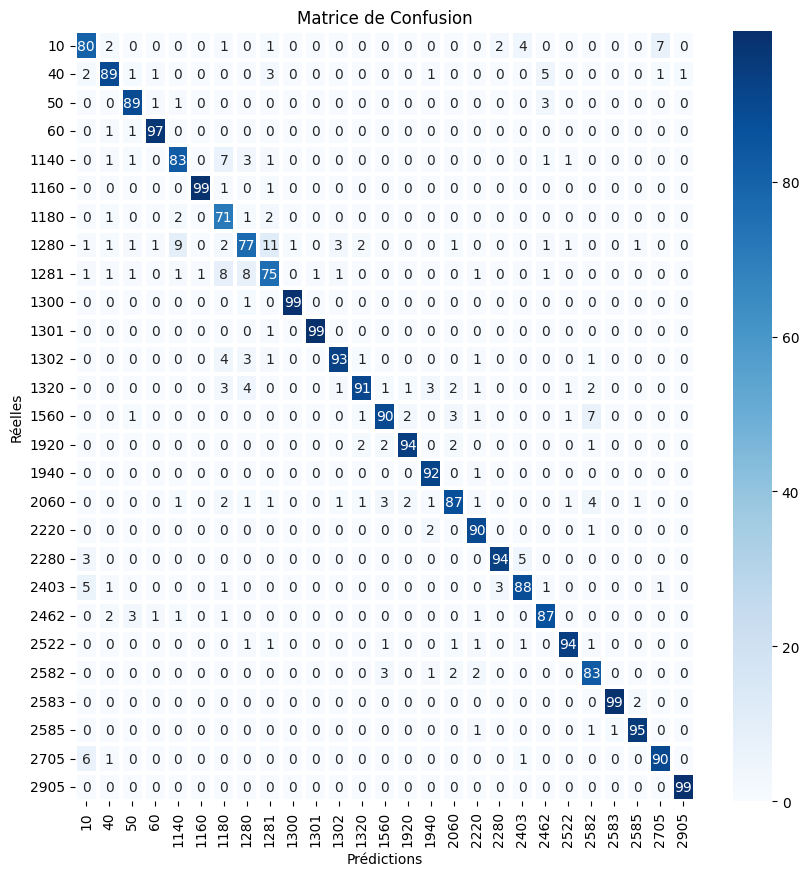

In [8]:
y_pred = model.predict([X1_test, X2_test,X3_test,X4_test,X5_test,X6_test])
y_pred_ids = np.argmax(y_pred, axis=-1)

trainer.evaluateTestResults(y_test,y_pred_ids)

 65/531 [==>...........................] - ETA: 1s

2023-09-27 22:00:01.162343: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



531/531 [==============================] - 1s 2ms/step
weighted F1 score: 0.9070935814957617


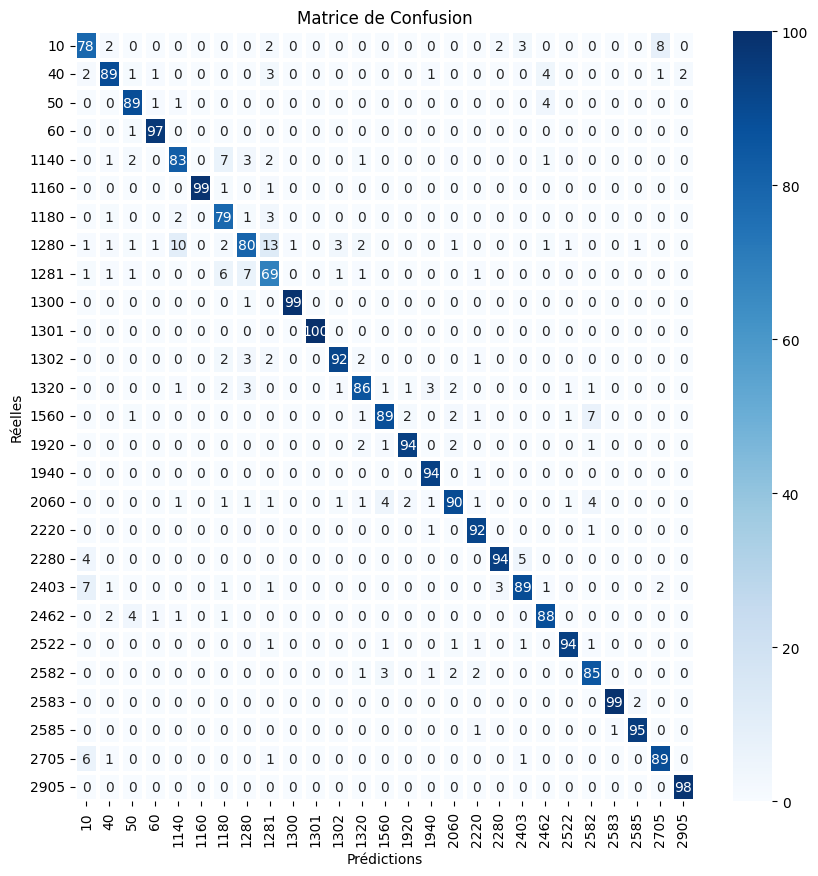

In [40]:
y_pred = model.predict([X1_test, X2_test,X3_test,X4_test,X5_test,X6_test])
y_pred_ids = np.argmax(y_pred, axis=-1)

trainer.evaluateTestResults(y_test,y_pred_ids)

In [ ]:
early_stopper = tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy', mode='auto', patience=2, 
            verbose=1, restore_best_weights=True
        ) 

model.fit([X1_train, X2_train, X3_train], y_train, epochs=10, batch_size=10, validation_data=([X1_val, X2_val,X3_val], y_val),callbacks=[early_stopper])

Epoch 1/10
  26/5435 [..............................] - ETA: 34s - loss: 0.1079 - accuracy: 0.9654

2023-09-25 11:34:52.936126: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
external_state_policy: POLICY_IGNORE
autotune_options {
}
warm_start: false



5427/5435 [============================>.] - ETA: 0s - loss: 0.0557 - accuracy: 0.9845

2023-09-25 11:35:24.270413: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



5435/5435 [==============================] - 35s 6ms/step - loss: 0.0557 - accuracy: 0.9845 - val_loss: 0.2507 - val_accuracy: 0.9451
Epoch 2/10
5435/5435 [==============================] - 34s 6ms/step - loss: 0.0534 - accuracy: 0.9847 - val_loss: 0.2515 - val_accuracy: 0.9453
Epoch 3/10
5435/5435 [==============================] - 33s 6ms/step - loss: 0.0529 - accuracy: 0.9845 - val_loss: 0.2536 - val_accuracy: 0.9458
Epoch 4/10
5435/5435 [==============================] - 33s 6ms/step - loss: 0.0493 - accuracy: 0.9860 - val_loss: 0.2539 - val_accuracy: 0.9458
Epoch 5/10
5435/5435 [==============================] - 40s 7ms/step - loss: 0.0502 - accuracy: 0.9857 - val_loss: 0.2548 - val_accuracy: 0.9464
Epoch 6/10
5435/5435 [==============================] - 34s 6ms/step - loss: 0.0472 - accuracy: 0.9872 - val_loss: 0.2555 - val_accuracy: 0.9464
Epoch 7/10
5435/5435 [==============================] - 35s 6ms/step - loss: 0.0477 - accuracy: 0.9869 - val_loss: 0.2562 - val_accuracy: 0.9